# Solution Exam 1

## Portfolio Management
### MLP Training

#### January 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

## Data

All the analysis below applies to the data set,
* `data/exam_1_data.xlsx`
* The file has **weekly** returns for the largest 10 stocks and SPY
* For annualization, use 52 periods per year.

### **<span style="color:red">Data Processing</span>**

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [3]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import performanceMetrics, maximumDrawdown, get_ols_metrics
from risk import *

In [4]:
INFILE = '../data/exam_1_data.xlsx'
SHEET_INFO = 'info'

FREQ = 52

In [5]:
info = pd.read_excel(INFILE,sheet_name=SHEET_INFO)
info.set_index('ticker',inplace=True)

In [6]:
rets = pd.read_excel(INFILE,sheet_name='total returns')
rets.set_index('date',inplace=True)
rets.columns = [s.split(' ')[0] for s in rets.columns]
rets = rets[info.index]


In [7]:
info

,shortName,quoteType,currency,volume,totalAssets,longBusinessSummary
ticker,,,,,,
SPY,SPDR S&P 500,ETF,USD,46716826,"623,795,240,960.0000",The trust seeks to achieve its investment obje...
AAPL,Apple Inc.,EQUITY,USD,36473385,NaN,"Apple Inc. designs, manufactures, and markets ..."
NVDA,NVIDIA Corporation,EQUITY,USD,218985854,NaN,NVIDIA Corporation provides graphics and compu...
MSFT,Microsoft Corporation,EQUITY,USD,14863983,NaN,Microsoft Corporation develops and supports so...
GOOGL,Alphabet Inc.,EQUITY,USD,24249066,NaN,Alphabet Inc. offers various products and plat...
AMZN,"Amazon.com, Inc.",EQUITY,USD,23698805,NaN,"Amazon.com, Inc. engages in the retail sale of..."
META,"Meta Platforms, Inc.",EQUITY,USD,9594911,NaN,"Meta Platforms, Inc. engages in the developmen..."
TSLA,"Tesla, Inc.",EQUITY,USD,71603819,NaN,"Tesla, Inc. designs, develops, manufactures, l..."
AVGO,Broadcom Inc.,EQUITY,USD,18145972,NaN,"Broadcom Inc. designs, develops, and supplies ..."


***

# 1. Risk Statistics and Decomposition

### 1.1.

Display a table with the following metrics for each of the return series.

* mean (annualized)
* volatility (annualized)
* Sharpe ratio (annualized)
* skewness
* kurtosis
* maximum drawdown

#### Note
We  have total returns, and Sharpe ratio is technically defined for excess returns. Don't worry about the difference.

#### Note
You might consider importing two functions from `cmds/portfolio`: `performanceMetrics` and `maximumDrawdown`. No need to use these, and you may well have implemented these calculations with your own (better) code in `Assignment 1`.

### 1.2.

As a standalone investment, which is most attractive? And least? Justify your answer.

### 1.3.

For each investment, estimate a regression against `SPY`. Report the 
* alpha (annualized as a mean)
* beta
* info ratio
* r-squared

Based on this table, which investment seems most attractive relative to holding `SPY`?

#### Note
You might consider importing two functions from `cmds/portfolio`: `get_ols_metrics`. No need to use it, and you may well have implemented these calculations with your own (better) code in `Assignment 2`.

### 1.4.

Suppose you expect `AAPL` to do well relatively, but you want to hedge broad market risk (`SPY`) and A.I. risk (`NVDA`). 

For every $100 in `AAPL`, what should you hold in `SPY` and `NVDA`?

### 1.5.

Without estimating anything new, consider the idea of replicating `AAPL` using `SPY`, and `NVDA`. Which regression statistic best indicates if your replication tracks the target well?

***

### **<span style="color:red">Solution 1.1.</span>**

In [8]:
mets = performanceMetrics(rets,annualization=FREQ)
mets['skewness'] = rets.skew()
mets['kurtosis'] = rets.kurtosis()
mets['max drawdown'] = maximumDrawdown(rets)['Max Drawdown']
mets.style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max,skewness,kurtosis,max drawdown
SPY,13.8%,16.8%,82.2%,-14.5%,12.1%,-57.6%,643.8%,-31.8%
AAPL,27.2%,27.0%,100.6%,-17.5%,14.7%,-14.8%,188.6%,-34.6%
NVDA,66.8%,45.4%,146.9%,-20.1%,30.2%,38.7%,155.4%,-65.9%
MSFT,26.5%,23.7%,112.0%,-14.4%,15.0%,1.3%,249.2%,-35.1%
GOOGL,23.6%,27.7%,85.5%,-12.0%,25.8%,62.7%,406.8%,-41.9%
AMZN,31.3%,30.4%,103.2%,-14.5%,18.5%,7.3%,189.3%,-54.8%
META,26.4%,34.8%,75.9%,-23.7%,24.5%,7.4%,438.2%,-76.0%
TSLA,50.6%,58.6%,86.3%,-25.9%,33.3%,53.7%,166.5%,-72.2%
AVGO,41.0%,36.2%,113.4%,-18.3%,25.2%,62.9%,350.7%,-39.7%
BRK-B,12.9%,18.8%,68.8%,-13.4%,9.8%,-23.6%,272.0%,-26.5%


### **<span style="color:red">Solution 1.2.</span>**

As a standalone investment, `NVDA` has
* the best Sharpe, which is the best vol-adjusted return.
* large **positive** skewness which is attractive.
* large kurtosis, which would be bad with negative skewness but is appealing with positive skewness.
* a large max drawdown.

If worried about the max drawdown, `LLY` may be a good choice.
* smallest max drawdown
* still has 4th hgihest Sharpe.

### **<span style="color:red">Solution 1.3.</span>**

In [9]:
get_ols_metrics(rets['SPY'],rets,FREQ).style.format('{:.1%}',na_rep='-')

,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
SPY,0.0%,100.0%,100.0%,13.8%,-
AAPL,11.9%,110.5%,47.1%,24.6%,60.8%
NVDA,43.2%,170.7%,39.7%,39.1%,122.6%
MSFT,12.3%,103.5%,53.8%,25.6%,76.1%
GOOGL,8.9%,107.2%,42.3%,22.1%,42.2%
AMZN,17.0%,104.4%,33.2%,30.0%,68.3%
META,11.0%,112.1%,29.2%,23.6%,37.5%
TSLA,26.3%,176.1%,25.4%,28.7%,52.0%
AVGO,23.2%,129.0%,35.8%,31.8%,80.1%
BRK-B,1.4%,83.5%,55.4%,15.5%,11.5%


Based on this table, `NVDA` is the most attractive. It not only has (by far) the highest alpha, but also the highest Info Ratio (which is the risk-adjusted alpha.)

### **<span style="color:red">Solution 1.4.</span>**

In [10]:
get_ols_metrics(rets[['SPY','NVDA']],rets[['AAPL']],FREQ).style.format('{:.1%}',na_rep='-')

,alpha,SPY,NVDA,r-squared,Info Ratio
AAPL,8.7%,97.9%,7.4%,48.1%,44.9%


For every $100 in `AAPL`, we would short 97.9 dollars of `SPY` and short 7.4 dollars of `NVDA`.

### **<span style="color:red">Solution 1.5.</span>**

The r-squared indicates how highly correlated our replication is to the target.

***

# 2. Portfolio Allocation

### 2.1.

Display the correlation matrix of the returns.

* Based on this information, which investment do you anticipate will get extra weight in the portfolio, beyond what it would merit for its mean return?

* Report the maximally correlated assets and the minimally correlated assets.

### 2.2.

Calculate the weights of the mean-variance optimized portfolio, also called the tangency portfolio.

* Display a table indexed by each investment, with the optimal weights in one column and the Sharpe ratios in another column.

* Do the investments with the best Sharpe ratios tend to get the biggest weights?

#### Note:
To estimate the optimal weights, consider using the provided function below.

In [11]:
def optimized_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, index=returns.columns)

### 2.3.

Report the following performance statistics of the portfolio achieved with the optimized weights calculated above.
* mean
* volatility
* Sharpe

(Annualize all three statistics.)

### 2.4.

Briefly explain why the optimized portfolio is unrealistic.

### 2.5.

Briefly explain what the optimizer likes about its biggest...
* long position.
* short position.

### 2.6. Extra, not graded.

Try dropping the asset which had the biggest short position from the investment set. Re-run the optimization. What do you think of these new weights compared to the original optimized weights?

What is going on?

****

### **<span style="color:red">Solution 2.1</span>**

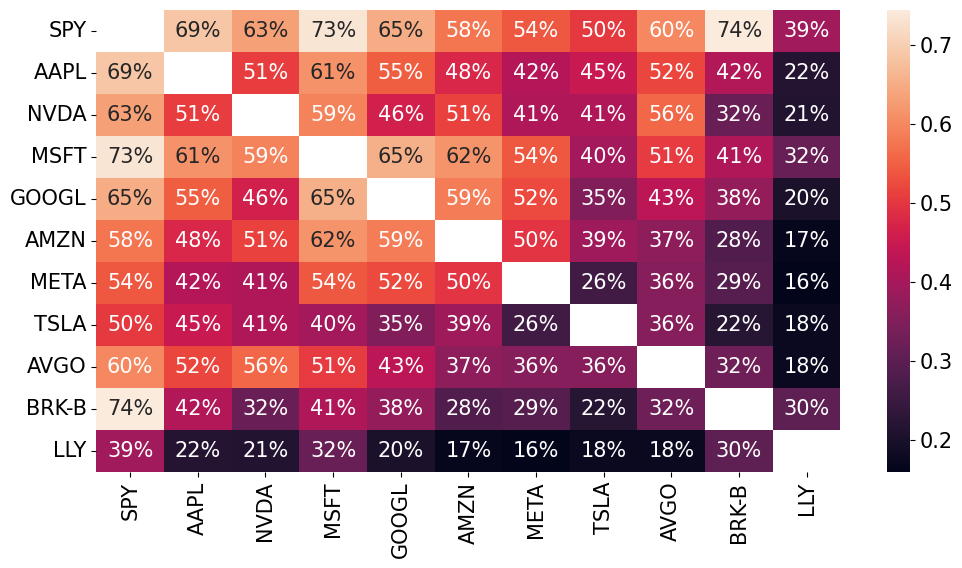

In [12]:
corrmat = rets.corr()
corrmat[corrmat==1] = None
sns.heatmap(corrmat,annot=True,fmt='.0%');

In [13]:
corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

MIN Correlation pair is ('LLY', 'META')
MAX Correlation pair is ('BRK-B', 'SPY')


### **<span style="color:red">Solution 2.2</span>**

In [14]:
wts = pd.DataFrame(index=rets.columns)
wts['optimized weights'] = optimized_weights(rets)

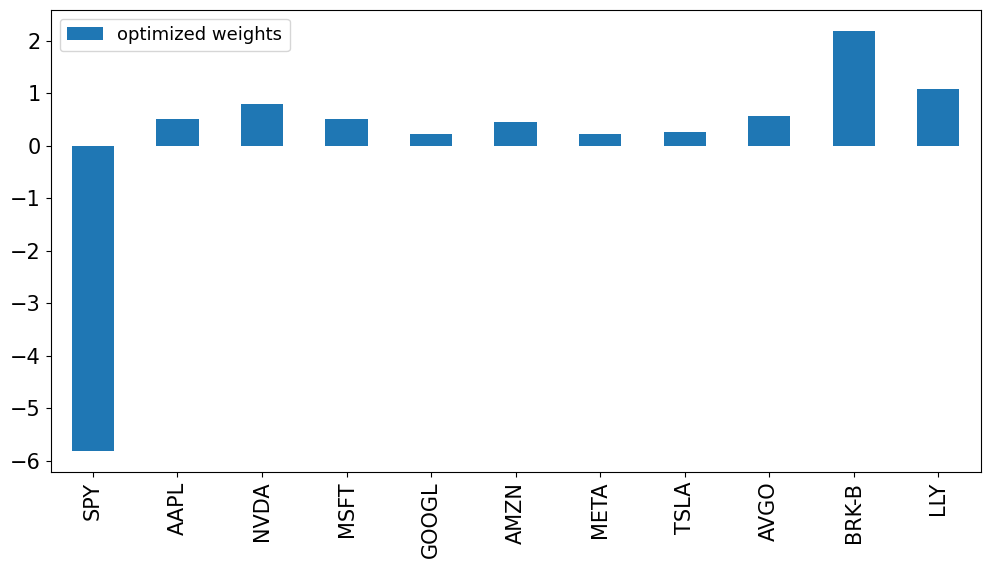

In [15]:
wts.plot.bar();

In [16]:
sharpe_vs_wts = pd.concat([wts['optimized weights'],mets['Sharpe']],axis=1)
sharpe_vs_wts.sort_values('optimized weights',ascending=False)

,optimized weights,Sharpe
BRK-B,2.1880,0.6880
LLY,1.0816,1.0934
NVDA,0.7988,1.4694
AVGO,0.5719,1.1336
AAPL,0.5100,1.0059
MSFT,0.5091,1.1200
AMZN,0.4462,1.0319
TSLA,0.2575,0.8633
GOOGL,0.2281,0.8548
META,0.2198,0.7594


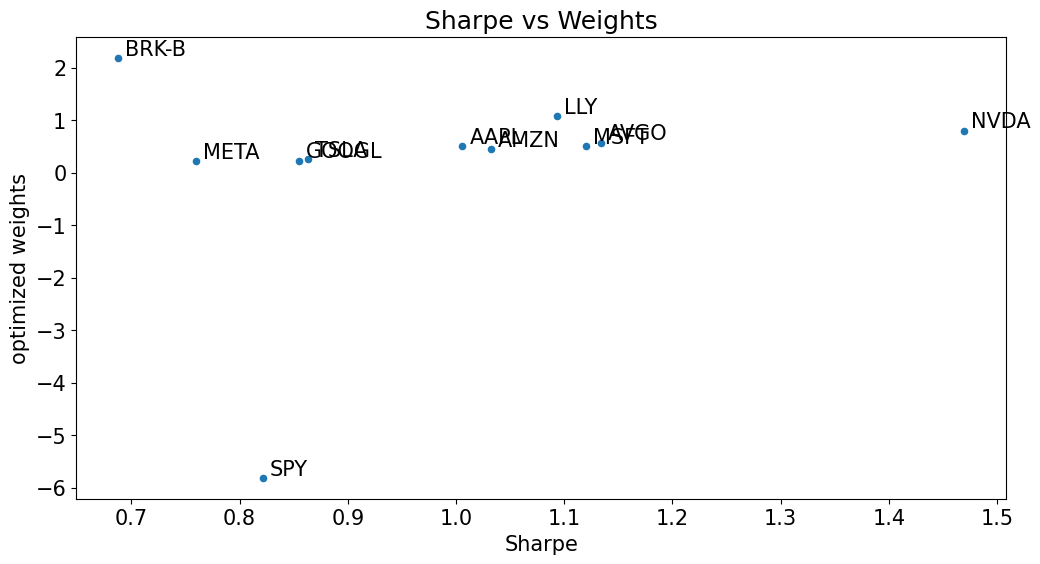

In [17]:
sharpe_vs_wts.plot.scatter(x='Sharpe',y='optimized weights')


for idx in sharpe_vs_wts.index:
    x_value = sharpe_vs_wts.loc[idx, "Sharpe"]
    y_value = sharpe_vs_wts.loc[idx, "optimized weights"]
    
    plt.annotate(
        text=idx,               
        xy=(x_value, y_value),  
        xytext=(5, 2),          
        textcoords="offset points"
    )

plt.xlabel("Sharpe")
plt.ylabel("optimized weights")
plt.title("Sharpe vs Weights")
plt.show()

### **<span style="color:red">Solution 2.3</span>**

In [18]:

port = pd.DataFrame(rets @ wts['optimized weights'],columns=['optimized weights'])
performanceMetrics(port,annualization=FREQ).style.format('{:.2%}')

,Mean,Vol,Sharpe,Min,Max
optimized weights,122.71%,57.21%,214.51%,-24.38%,28.79%


### **<span style="color:red">Solution 2.4</span>**

The optimization is unrealistic in that it prescribes massive positions.
* `SPY` is short nearly 600%.
* `BRK-B` is long nearly 200%.

### **<span style="color:red">Solution 2.5</span>**


The optimizer is shorting `SPY` because...
* it has lower mean return than the tech stocks (`NVDA`) 
* it is highly correlated to the tech stocks and can offset much of their risk.

The optimizer is massively long `BRK`...
* even though `BRK` has the **worst** Sharpe ratio of the investments.
* But `BRK` is highly correlated to `SPY` while having relatively low correlation to tech. Thus it lowers total risk.

***

### Extra: Sensitivity to dropping `SPY`

In [19]:
DROPTICK = 'SPY'

In [20]:
wts[f'optimized ex {DROPTICK}'] = optimized_weights(rets.drop(columns=[DROPTICK]))
wts.loc[f'{DROPTICK}',f'optimized ex {DROPTICK}'] = 0

port[f'optimized ex {DROPTICK}'] = pd.DataFrame(rets @ wts[f'optimized ex {DROPTICK}'],columns=[f'optimized ex {DROPTICK}'])

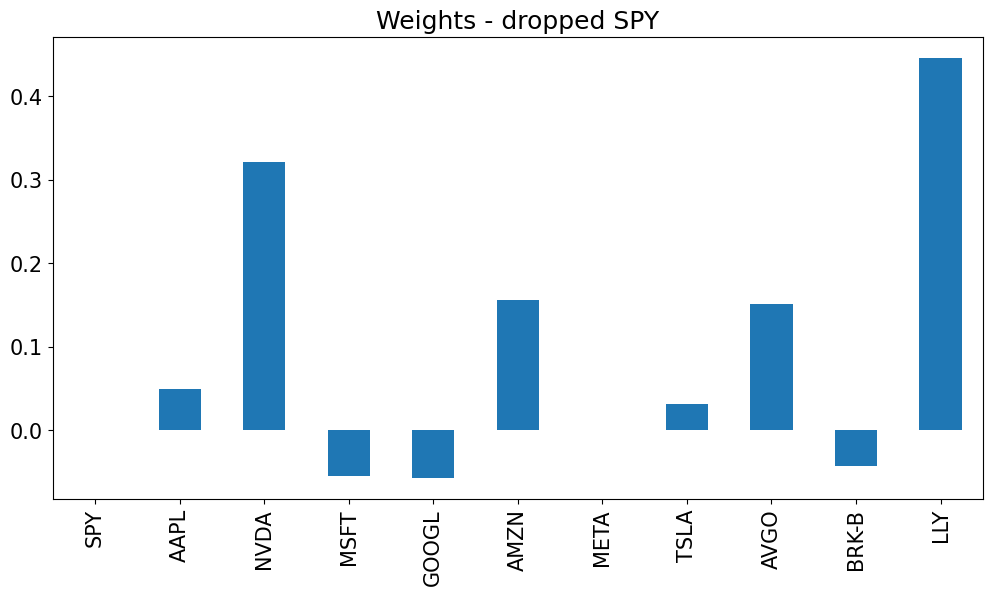

In [21]:
wts[f'optimized ex {DROPTICK}'].plot.bar();
plt.title(f'Weights - dropped {DROPTICK}');

These weights are much more realistic. They are reasonable magnitudes and don't include massive short positions.

Without `SPY`, the correlation matrix has relatively low correlations. Thus, the optimizer doesn't think it can achieve such balanced (hedged) offsets, so it doesn't prescribe extremes. 

In [22]:
performanceMetrics(port,annualization=FREQ)

,Mean,Vol,Sharpe,Min,Max
optimized weights,1.2271,0.5721,2.1451,-0.2438,0.2879
optimized ex SPY,0.4533,0.2625,1.7270,-0.1161,0.1515
